Our aim here is to make our first code for a Neural Network(NN). 
Our ideia is to make it step-by-step, starting by using very fundamental tools and methods
and then advancing for more complicated methods but also some stronger tools...
We will be using the MNIST data_set... This data set will be explained during the code.
Since our NN will be constantly changing as we proceed, we will not set any goals for the NN right now.

We will be using TensorFlow for the moment : 

In [2]:
import tensorflow as tf #lib for NN
import tensorflow_datasets as tfds #lib to build more efficient data sets
from tensorflow import keras
from tensorflow.keras import layers, Sequential, optimizers,losses
import matplotlib.pyplot as plt #lib to plot
import numpy as np
import tqdm  as tqdm
import os

# Load Data

First step is to import MNIST and understand the Data. <br>
Well the MNIST data set is already build-in ``tensorflow_datasets`` that you can dowload using <br> 
`` pip install tensorflow_datasets``.

In [5]:
ds = tfds.load('mnist')
ds

{'train': <PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

Now the Data_set (``ds``) is stored in ``\tensorflow_datasets\mnist\3.0.1`` for future use. <br>
Alternatively we could also download it directly from the original website (http://yann.lecun.com/exdb/mnist/)

In [48]:
ds #we have a split between 'train' and 'test', both containg images 28x28 pixels and labels from 0 to 9

{Split('train'): <PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 Split('test'): <PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [67]:
#directly from the website :
#path_train_data = tf.keras.utils.get_file(fname = 'traindata_mnist', origin = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", extract = True, archive_format = 'zip')
#path_train_label =  tf.keras.utils.get_file(fname = 'trainlabel_mnist', origin = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', extract = True, archive_format = 'zip')

28881/28881 [==============================] - 0s 0s/step


This files are in a IDX format... so we will just use the keras built-in dataset that comes in a more readable format <br>
Since they come in a split format for 'traindata, trainlabel' and 'testdata,testlabel' we need to :

# Separate & Check your Data

In [5]:
train = ds.get('train') #get the split train, 
batches = train.shuffle(1000).repeat().batch(32) #divide in batches with 32 elements, (this will make future computations quick.. what we are doing is making a stochastic gradient descent)
                                                #to better understant .shuffle and repeat read https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
                                                #but it will basically take a random element from the first 1000 elements and fill with the element #1001
                                                #then it will do this until all data set is over and then .repeat()... each 32 elements chosen from the 1000 will go to the batch
for i in batches.take(1):                     #to visualize lets take the first batch
    image, label = i['image'], i['label']
    print(label)
    print(image.shape)                        #so we have 32 pictures of 28x28 ranging from 0 to 9 



tf.Tensor([0 4 0 4 7 5 3 9 6 7 4 5 0 7 6 9 8 3 0 2 6 5 3 4 2 6 3 2 5 3 1 7], shape=(32,), dtype=int64)
(32, 28, 28, 1)


tf.Tensor(0, shape=(), dtype=int64)


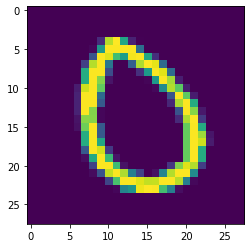

In [6]:
plt.imshow(image[0,:,:,:]) #lets plot the first image
print(label[0])


So that's how our data looks like!!

It will be smart to apply some transformations to this data, but we will leave that for later <br>
Now we will start to build our layers for our NN <br>
First we have to build our set of variable for each layer (weights and bias). Lets start with 3 layers (#nodes in each: 256, 128, and 10) :

For the sake of simplicity here we will use for now as input the first element of the first batch

In [16]:
X = image[0]
X = tf.reshape(X, [-1, 28*28]) #reshape the images to just one array of size 28*28
X = tf.cast(X, dtype=tf.float32) #int8 cannot be multiplied as matrix with float32
Y = label[0]
Y = tf.expand_dims(Y,0)

# Set your weights and layers



In [17]:
w1 = tf.Variable(tf.random.truncated_normal([784, 256], 
stddev=0.1))
b1 = tf.Variable(tf.zeros([256])) #bias
w2 = tf.Variable(tf.random.truncated_normal([256, 128], 
stddev=0.1))
b2 = tf.Variable(tf.zeros([128]))
w3 = tf.Variable(tf.random.truncated_normal([128, 10], #output will have 10 layers
stddev=0.1))
b3 = tf.Variable(tf.zeros([10])) 
w1

<tf.Variable 'Variable:0' shape=(784, 256) dtype=float32, numpy=
array([[-0.05936557,  0.04639177,  0.02347607, ..., -0.06387068,
        -0.02620685,  0.03868044],
       [-0.1952682 ,  0.06805103,  0.17102274, ..., -0.01344233,
         0.03949027,  0.05462182],
       [-0.04221346, -0.17029685,  0.04309071, ...,  0.05533034,
         0.02619618,  0.09960728],
       ...,
       [-0.06732056,  0.17205769,  0.15260576, ...,  0.05691807,
        -0.05964646, -0.17759334],
       [-0.15292616,  0.13384157,  0.05935417, ..., -0.01007792,
        -0.00542173,  0.04844937],
       [-0.0938056 , -0.05154423,  0.07881131, ..., -0.11234354,
        -0.11219404,  0.0242757 ]], dtype=float32)>

We then apply some non-linear functions (activation function) to each layer

In [9]:
h1 = X@w1 + b1
h1 = tf.nn.relu(h1)
h2 = h1@w2 + b2
h2 = tf.nn.relu(h2)
out = h2@w3 + b3
out = tf.nn.relu(out)

Our lost function is : 

In [ ]:
y_onehot = tf.one_hot(Y,len(out[0]))  #one hot encoding                     
loss = tf.square(y_onehot - out)      #mse
loss = tf.reduce_mean(loss)
loss,out

# Apply the gradient

After we have to compute the gradients :

In [11]:
with tf.GradientTape(watch_accessed_variables=True) as tape : #this will compute and keep track of the grads
    h1 = X@w1 + b1
    h1 = tf.nn.relu(h1)
    h2 = h1@w2 + b2
    h2 = tf.nn.relu(h2)
    out = h2@w3 + b3
    out = tf.nn.relu(out)
    y_onehot = tf.one_hot(Y,len(out[0]))                       
    loss = tf.square(y_onehot - out)
    loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, [w1,b1,w2,b2,w3,b3]) 

Lets see an example of how ``GradientTape()`` works

In [633]:
with tf.GradientTape(watch_accessed_variables=True) as g : 
    a = tf.Variable(2.0)
    c = tf.Variable(5.0)
    w = (2*a+c)      
    z = w**2 + a**2  #(dzdw = 2w & dzda = 2a + 2(2a+c)*2)
    grads = g.gradient(z,[w,a])
print(grads)

[<tf.Tensor: shape=(), dtype=float32, numpy=18.0>, <tf.Tensor: shape=(), dtype=float32, numpy=40.0>]


# Gradient Descent

The gradient descent will be given by : 

In [12]:
lr = 0.1                         #learing rate
w1.assign_sub(lr * grads[0])
b1.assign_sub(lr * grads[1])
w2.assign_sub(lr * grads[2])
b2.assign_sub(lr * grads[3])
w3.assign_sub(lr * grads[4])
b3.assign_sub(lr * grads[5])     #it will print just this value

<tf.Variable 'UnreadVariable' shape=(10,) dtype=float32, numpy=
array([-1.6684399 ,  0.        , -0.54000646, -3.3968327 ,  0.        ,
        0.        ,  0.        ,  0.        , -1.0109125 , -1.2688493 ],
      dtype=float32)>

Now we need to apply all new value of (w1,b1..w3,b3) back into the gradient <br>
and so on until we get close to a minimum (lets iterate 10 times)

In [18]:
lr = 0.001                         #learing rate
allloss = np.array(tf.zeros([11]))
allloss[0] = loss
loss #print initial loss
for i in range(10):
    with tf.GradientTape(watch_accessed_variables=True) as tape : #this will compute and keep track of the grads
        h1 = X@w1 + b1
        h1 = tf.nn.relu(h1)
        h2 = h1@w2 + b2
        h2 = tf.nn.relu(h2)
        out = h2@w3 + b3
        out = tf.nn.relu(out)
        y_onehot = tf.one_hot(Y,len(out[0]))                       
        loss = tf.square(y_onehot - out)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, [w1,b1,w2,b2,w3,b3])
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])
        w3.assign_sub(lr * grads[4])
        b3.assign_sub(lr * grads[5])
        allloss[i+1] = loss
        print(out)
    

tf.Tensor(
[[ 58.074997   0.       133.05505   87.66293  192.92175    0.
    0.         0.       110.67337  177.21835 ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[     0.         0.         0.         0.         0.     40043.914
  329444.78       0.         0.         0.   ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.5884713e+10 0.0000000e+00 0.0000000e+00]], shape=(1, 10), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(

In [19]:
allloss

array([1.0000000e-01, 1.0951974e+04, 1.1013738e+10, 2.5232411e+19,
       1.0000000e-01, 1.0000000e-01, 1.0000000e-01, 1.0000000e-01,
       1.0000000e-01, 1.0000000e-01, 1.0000000e-01], dtype=float32)

Well we see that after only 3 iterations our NN finds a minimun of the loss function <br>
for a loss of 0.1...

In [20]:
out,y_onehot


(<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>)

# For more Images

Let's do for a full batch :

In [29]:
X = image                    #whole batch (32,28,28,1)
X = tf.reshape(X, [-1, 28*28]) 
X = tf.cast(X, dtype=tf.float32)
Y = label                        #all labels in batch
w1 = tf.Variable(tf.random.truncated_normal([784, 256], stddev=0.1))
b1 = tf.Variable(tf.zeros([256])) 
w2 = tf.Variable(tf.random.truncated_normal([256, 128], 
stddev=0.1))
b2 = tf.Variable(tf.zeros([128]))
w3 = tf.Variable(tf.random.truncated_normal([128, 10], stddev=0.1))
b3 = tf.Variable(tf.zeros([10])) 

In [23]:
lr = 0.000001                       
allloss = np.array(tf.zeros([100]))
for i in range(100):
    with tf.GradientTape(watch_accessed_variables=True) as tape : #this will compute and keep track of the grads
        h1 = X@w1 + b1
        h1 = tf.nn.relu(h1)
        h2 = h1@w2 + b2
        h2 = tf.nn.relu(h2)
        out = h2@w3 + b3
        out = tf.nn.relu(out)
        y_onehot = tf.one_hot(Y,len(out[0])) #this is (1,32,10)
        loss = tf.square(y_onehot - out)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, [w1,b1,w2,b2,w3,b3])
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])
        w3.assign_sub(lr * grads[4])
        b3.assign_sub(lr * grads[5])
        allloss[i] = loss
        

0.4217759


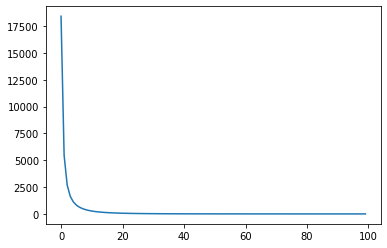

In [24]:
plt.plot(range(100),allloss)
print(allloss[-1])

Something strange is happening.. the LR has to be very small, otherwise
the models will make all our inputs go to 0 <br>
   

Well if we look closer at how we made our output we see that there is a very big mistake,<br>
"out" is supposed to give a probability for each label... but this cannot be achive using Relu <br>
instead we should use a softmax... Before doing that let's see what happens if we "rescale" the values of the<br> input so that they are closer 
to y_onehot. So taking X to X/255 we should see a different behavior, mainly the loss should start with lower values.


Instead of copying again and again our code we can also define a class that will 
cover all our steps

# Classes

In [30]:
class MyFirstNN:
    
    """ This is a class for our First NN it will return a vector with the loss for each iteration"""
    


    def __init__(self,image_train,label_train):
        self.w1 = tf.Variable(tf.random.truncated_normal([784, 256], stddev=0.1))
        self.b1 = tf.Variable(tf.zeros([256])) 
        self.w2 = tf.Variable(tf.random.truncated_normal([256, 128], stddev=0.1))
        self.b2 = tf.Variable(tf.zeros([128]))
        self.w3 = tf.Variable(tf.random.truncated_normal([128, 10], stddev=0.1))
        self.b3 = tf.Variable(tf.zeros([10]))
        self.image_train = tf.reshape(image_train, [-1, 28*28]) 
        self.image_train = tf.cast(self.image_train, dtype=tf.float32) #transform our input and output 
        self.image_train = self.image_train/255                        #normalize
        self.label_train = label_train
        

    def fitRelu(self,iterations,lr):
        alllossRelu = np.array(tf.zeros(iterations))
        for i in range(iterations):
            with tf.GradientTape(watch_accessed_variables=True) as tape : #this will compute and keep track of the grads
                h1 = self.image_train@self.w1 + self.b1
                h1 = tf.nn.relu(h1)
                h2 = h1@self.w2 + self.b2
                h2 = tf.nn.relu(h2)
                out = h2@self.w3 + self.b3
                out = tf.nn.relu(out)
                y_onehot = tf.one_hot(self.label_train,len(out[0]))
                loss = tf.square(y_onehot - out)
                loss = tf.reduce_mean(loss)
                grads = tape.gradient(loss, [self.w1,self.b1,self.w2,self.b2,self.w3,self.b3])
                self.w1.assign_sub(lr * grads[0])
                self.b1.assign_sub(lr * grads[1])
                self.w2.assign_sub(lr * grads[2])
                self.b2.assign_sub(lr * grads[3])
                self.w3.assign_sub(lr * grads[4])
                self.b3.assign_sub(lr * grads[5])
                alllossRelu[i] = loss
        return alllossRelu
    
    def fitSoft(self,iterations,lr):                           #we create a possibility of choosing SoftMax
        alllossSoft = np.array(tf.zeros(iterations))
        for i in range(iterations):
            with tf.GradientTape(watch_accessed_variables=True) as tape : #this will compute and keep track of the grads
                h1 = self.image_train@self.w1 + self.b1
                h1 = tf.nn.relu(h1)
                h2 = h1@self.w2 + self.b2
                h2 = tf.nn.relu(h2)
                out = h2@self.w3 + self.b3
                out = tf.nn.softmax(out)
                y_onehot = tf.one_hot(self.label_train,len(out[0]))
                loss = tf.square(y_onehot - out)
                loss = tf.reduce_mean(loss)
                grads = tape.gradient(loss, [self.w1,self.b1,self.w2,self.b2,self.w3,self.b3])
                self.w1.assign_sub(lr * grads[0])
                self.b1.assign_sub(lr * grads[1])
                self.w2.assign_sub(lr * grads[2])
                self.b2.assign_sub(lr * grads[3])
                self.w3.assign_sub(lr * grads[4])
                self.b3.assign_sub(lr * grads[5])
                alllossSoft[i] = loss
        return alllossSoft
                

In [26]:
lossrelu = MyFirstNN(image,label).fitRelu(1000,0.1)

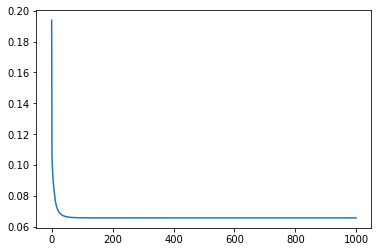

In [27]:
plt.plot(range(1000),lossrelu)

In [28]:
lossrelu[-1]

0.065625

So we can achieve better result with a bigger LR.(see how it starts in a better point) <br>
Lets see now what happens if we change our last activation fuction to a SoftMax

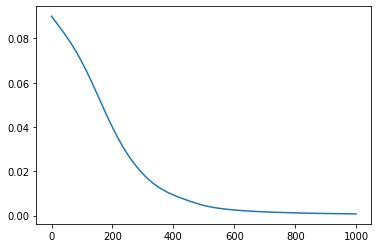

In [31]:
losssoft = MyFirstNN(image,label).fitSoft(1000,0.1)
plt.plot(range(1000),losssoft)

In [32]:
losssoft[-1]

0.00078565534

The softmax is able to minimize the loss function even better.. <br>
We should at this moment explore our other batches <br>
For this we will introduce the concept of epochs... <br>
Before that... there is no reason to keep using the raw format for out NN, since Keras can do it with a <br>
more compact format.

# Keras Sequential

In [390]:
network = Sequential([layers.Dense(256, activation='relu'),
layers.Dense(128, activation='relu'),
layers.Dense(10, activation='softmax')])
network.build(input_shape = [32,28*28])
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (32, 256)                 200960    
                                                                 
 dense_50 (Dense)            (32, 128)                 32896     
                                                                 
 dense_51 (Dense)            (32, 10)                  1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [1534]:
for p in network.trainable_variables:
 print(p.name, p.shape)

dense_15/kernel:0 (784, 256)
dense_15/bias:0 (256,)
dense_16/kernel:0 (256, 128)
dense_16/bias:0 (128,)
dense_17/kernel:0 (128, 10)
dense_17/bias:0 (10,)


# Get all Data

In [3]:
train = ds.get('train') 

for i in tqdm.tqdm(train.shuffle(train.cardinality()).batch(train.cardinality())):                     
    image, label = i['image'], i['label']

100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Now we pass a Loss fuction : 

In [392]:
X = image/255                    #whole batch (60000,28,28,1)
X = tf.reshape(X, [-1, 28*28]) 
X = tf.cast(X, dtype=tf.float32)
Y = label
Y = tf.one_hot(Y,10) 

In [393]:
network.compile(optimizer=optimizers.Adam(learning_rate=0.001), #we use Adam as optimizer for the gradient descent
            loss = losses.CategoricalCrossentropy(), #logits = false cuz we already have a softmax before
            metrics=['accuracy'])

Before I omitted the necessity of defining a validation set to analize our model and
correct our hyperparamets... <br> the good part is that our method fit() can already define a validation set <br>
be aware that our data should be shuffled already since the internal shuffle is applied after defining the val set

# Fit and Plot the model

In [394]:
history = network.fit(X,Y, epochs = 32,batch_size=128, verbose=0, validation_split=0.2, shuffle=True)

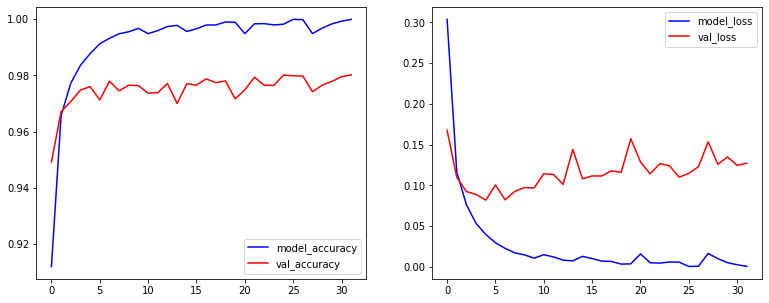

'loss': 0.0006083629559725523 
'accuracy' : 0.9998958110809326 
'val_loss' : 0.12716639041900635 
'val_accuracy' : 0.9801666736602783


In [9]:

fig, ax = plt.subplots(1, 2,figsize=(13,5))
ax[0].plot(np.arange(32),history.history.get('accuracy'),color='blue',label='model_accuracy')
ax[0].plot(np.arange(32),history.history.get('val_accuracy'), color='red',label='val_accuracy')
ax[1].plot(np.arange(32),history.history.get('loss'), color='blue' ,label='model_loss')
ax[1].plot(np.arange(32),history.history.get('val_loss'), color='red',label='val_loss')


ax[0].legend()
ax[1].legend()
plt.show()
print("'loss':" ,history.history.get('loss')[-1], '\n' "'accuracy' :", history.history.get('accuracy')[-1],  '\n' "'val_loss' :", history.history.get('val_loss')[-1], '\n' "'val_accuracy' :" ,history.history.get('val_accuracy')[-1])

An explanation of why the ``val_loss`` grows while it's accuracy also grows is because the model<br>
might have found some outliers in the validation set that make the loss very big on then..

'Now we would like to check our predictions : 

We first load our test images

# Evaluate the Model on the training set

In [25]:
test = ds.get('test')
for i in tqdm.tqdm(test.shuffle(test.cardinality()).batch(test.cardinality())):                     
    image_test, label_test = i['image'], i['label']

100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


In [6]:
Xt = image_test/255                    
Xt = tf.reshape(Xt, [-1, 28*28]) 
Xt = tf.cast(Xt, dtype=tf.float32)
Yt = label_test
Yt = tf.one_hot(Yt,10)

100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Let's see if our model predicts the first test image : 

(<matplotlib.image.AxesImage at 0x1ef81b30fd0>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>)

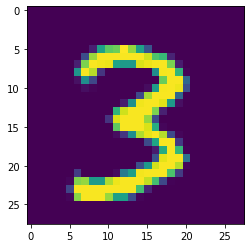

In [44]:
topred = tf.one_hot(label_test[0],10)
plt.imshow(tf.squeeze(image_test[0], axis=2)), topred

So we want to predict an 3... ``topred`` is just the one hot of 3

In [51]:
image_test = tf.reshape(image_test, [-1, 28*28]) 
image_test = tf.cast(image_test, dtype=tf.float32)
pred = network.predict(image_test)[0]
pred

313/313 [==============================] - 0s 1ms/step


array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [52]:
pred_hot = tf.math.argmax(pred)
pred_hot

<tf.Tensor: shape=(), dtype=int64, numpy=3>

So we see that it gives the right prediction. In fact if we do for all images in test :

In [395]:
network.evaluate(Xt,Yt)

313/313 [==============================] - 0s 1ms/step - loss: 0.0977 - accuracy: 0.9818


[0.09766785800457001, 0.9818000197410583]

So we have an accuracy of 98.2% on our test set

To visualize this lets print our prediction together with the correct image for a set of 36 images

# Make Predictions

In [57]:
prediction = network.predict(Xt)

313/313 [==============================] - 0s 1ms/step


100%|██████████| 36/36 [00:00<00:00, 81.00it/s]


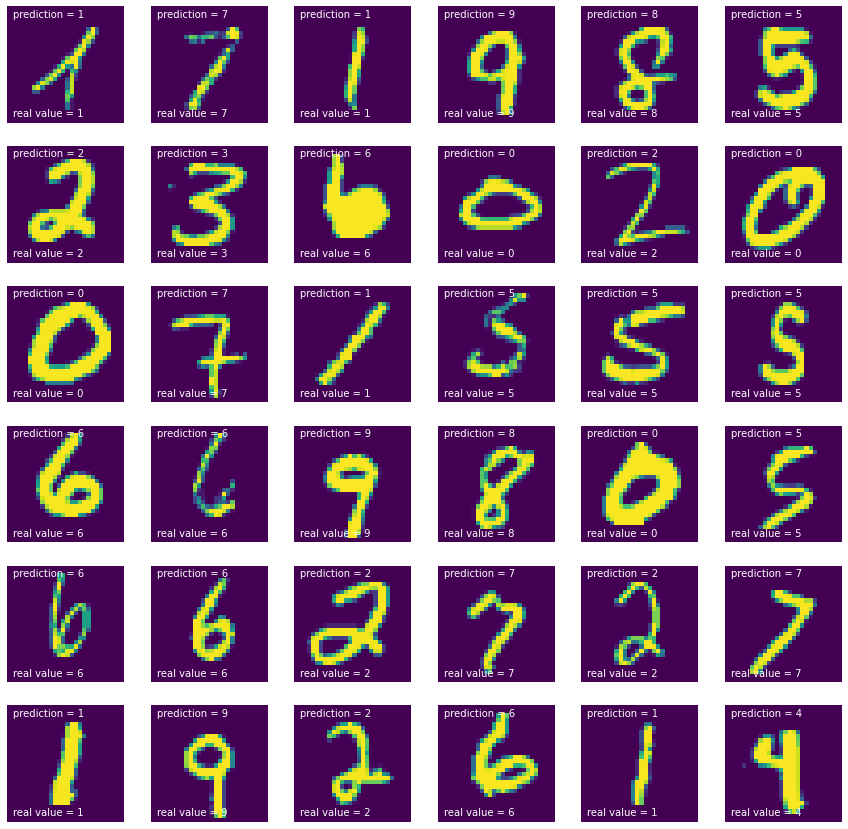

In [252]:
fig = plt.figure(figsize=(15, 15))
for i in tqdm.tqdm(range(36)):
    fig.add_subplot(6,6, i+1)
    plt.imshow(tf.squeeze(image_test[i+9500], axis=2))      #THE REASON WE ARE TAKING THE LAST NUMBERS IS BECAUSE THEY ARE 
    a = tf.math.argmax(prediction[i+9500])                  #THE MOST DIFICULT ONES TO PREDICT (dirty data)
    b = label_test[i+9500]
    plt.text(1,2,'prediction = %s' %(a.numpy()), color = 'white')
    plt.text(1,26,'real value = %s' %(b.numpy()), color='white', rotation='horizontal')
    plt.axis('off')


For the sake of curiosity let's see what happens if we insert some dropout layers

# Drop Outs - Explicit Regularization

In [33]:
networkA = Sequential([layers.Dense(256, activation='relu'),
layers.Dropout(0.5),
layers.Dense(128, activation='relu'),
layers.Dropout(0.5),
layers.Dense(10, activation='softmax')])
networkA.build(input_shape = [32,28*28])
networkA.summary()
networkA.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
            loss = losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (32, 256)                 200960    
                                                                 
 dropout_12 (Dropout)        (32, 256)                 0         
                                                                 
 dense_25 (Dense)            (32, 128)                 32896     
                                                                 
 dropout_13 (Dropout)        (32, 128)                 0         
                                                                 
 dense_26 (Dense)            (32, 10)                  1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [34]:
historyA = networkA.fit(X,Y, epochs = 32,batch_size=128, verbose=0, validation_split=0.2, shuffle=True)

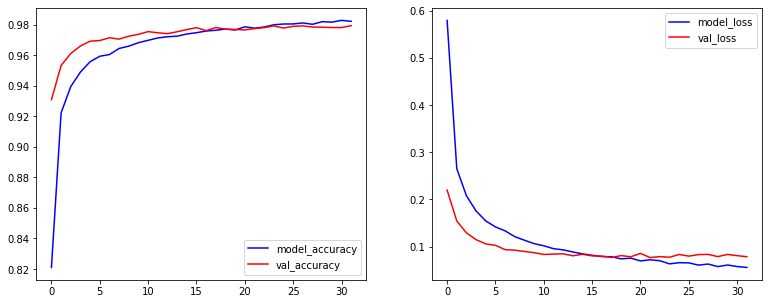

'loss': 0.055741190910339355 
'accuracy' : 0.9821458458900452 
'val_loss' : 0.07851549983024597 
'val_accuracy' : 0.9793333411216736


In [35]:

fig, ax = plt.subplots(1, 2,figsize=(13,5))
ax[0].plot(np.arange(32),historyA.history.get('accuracy'),color='blue',label='model_accuracy')
ax[0].plot(np.arange(32),historyA.history.get('val_accuracy'), color='red',label='val_accuracy')
ax[1].plot(np.arange(32),historyA.history.get('loss'), color='blue' ,label='model_loss')
ax[1].plot(np.arange(32),historyA.history.get('val_loss'), color='red',label='val_loss')


ax[0].legend()
ax[1].legend()
plt.show()
print("'loss':" ,historyA.history.get('loss')[-1], '\n' "'accuracy' :", historyA.history.get('accuracy')[-1],  '\n' "'val_loss' :", historyA.history.get('val_loss')[-1], '\n' "'val_accuracy' :" ,historyA.history.get('val_accuracy')[-1])

In [36]:
networkA.evaluate(Xt,Yt)

313/313 [==============================] - 0s 1ms/step - loss: 0.0766 - accuracy: 0.9813


[0.07662434130907059, 0.9812999963760376]

We see that it will kill that strange effect of ``val_loss`` growing.. that can be explained <br>
by imagining that from time to time the outliers would be killed and will not influece so much. <br>
Notice that the Accuracy of the model continues 98.1%. Droouts are a very good way to avoid overfitting.

# More Layers 

What if we add more hidden layers ? 

In [46]:
networkAA = Sequential([layers.Dense(256, activation='relu'),
layers.Dropout(0.5),
layers.Dense(128, activation='relu'),
layers.Dropout(0.5),
layers.Dense(64, activation='relu'),                        #overall this doest add many more parameters
layers.Dropout(0.5),
layers.Dense(32, activation='relu'),
layers.Dropout(0.5),
layers.Dense(16, activation='relu'),
layers.Dropout(0.5),
layers.Dense(10, activation='softmax')])
networkAA.build(input_shape = [32,28*28])
networkAA.summary()
networkAA.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
            loss = losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (32, 256)                 200960    
                                                                 
 dropout_23 (Dropout)        (32, 256)                 0         
                                                                 
 dense_39 (Dense)            (32, 128)                 32896     
                                                                 
 dropout_24 (Dropout)        (32, 128)                 0         
                                                                 
 dense_40 (Dense)            (32, 64)                  8256      
                                                                 
 dropout_25 (Dropout)        (32, 64)                  0         
                                                                 
 dense_41 (Dense)            (32, 32)                

In [47]:
historyAA = networkAA.fit(X,Y, epochs = 32,batch_size=128, verbose=0, validation_split=0.2, shuffle=True)

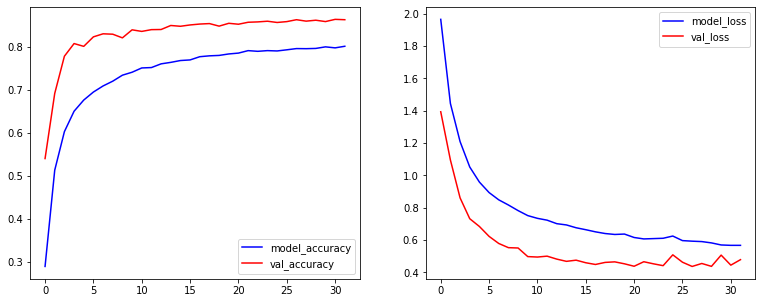

'loss': 0.5677388906478882 
'accuracy' : 0.8016250133514404 
'val_loss' : 0.4791480600833893 
'val_accuracy' : 0.8633333444595337


In [48]:
fig, ax = plt.subplots(1, 2,figsize=(13,5))
ax[0].plot(np.arange(32),historyAA.history.get('accuracy'),color='blue',label='model_accuracy')
ax[0].plot(np.arange(32),historyAA.history.get('val_accuracy'), color='red',label='val_accuracy')
ax[1].plot(np.arange(32),historyAA.history.get('loss'), color='blue' ,label='model_loss')
ax[1].plot(np.arange(32),historyAA.history.get('val_loss'), color='red',label='val_loss')
ax[0].legend()
ax[1].legend()
plt.show()
print("'loss':" ,historyAA.history.get('loss')[-1], '\n' "'accuracy' :", historyAA.history.get('accuracy')[-1],  '\n' "'val_loss' :", historyAA.history.get('val_loss')[-1], '\n' "'val_accuracy' :" ,historyAA.history.get('val_accuracy')[-1])

In [49]:
networkAA.evaluate(Xt,Yt)

313/313 [==============================] - 0s 1ms/step - loss: 0.5431 - accuracy: 0.8612


[0.5430874824523926, 0.8611999750137329]

# Keras Functional API

Maybe too many layers ? Let's take one out. <br>
We will also use this new NN to introduce the Keras Functional API (it gives us more flexibility)... <br> until now we were using 
the tf.keras.Sequential

Model: "5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_29 (Dense)            (None, 256)               200960    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         

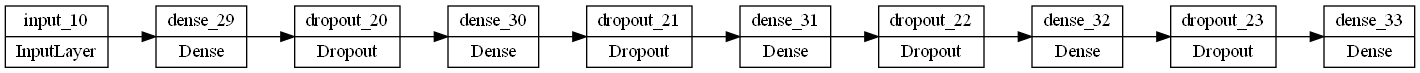

In [352]:
inputs = keras.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)                        #overall this doest add many more parameters
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(10, activation='softmax')(x)
networkAAA = keras.Model(inputs, output, name="5")
networkAAA.summary()
keras.utils.plot_model(networkAAA,rankdir='LR')

In [353]:
networkAAA.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
            loss = losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

In [354]:
historyAAA = networkAAA.fit(X,Y, epochs = 32,batch_size=128, verbose=0, validation_split=0.2, shuffle=True)

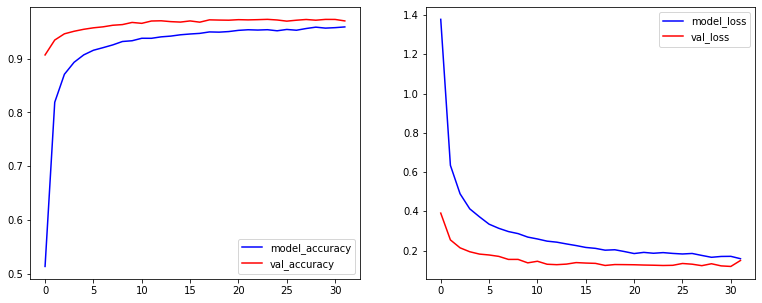

'loss': 0.15816347301006317 
'accuracy' : 0.9589999914169312 
'val_loss' : 0.14913727343082428 
'val_accuracy' : 0.9701666831970215


In [355]:
fig, ax = plt.subplots(1, 2,figsize=(13,5))
ax[0].plot(np.arange(32),historyAAA.history.get('accuracy'),color='blue',label='model_accuracy')
ax[0].plot(np.arange(32),historyAAA.history.get('val_accuracy'), color='red',label='val_accuracy')
ax[1].plot(np.arange(32),historyAAA.history.get('loss'), color='blue' ,label='model_loss')
ax[1].plot(np.arange(32),historyAAA.history.get('val_loss'), color='red',label='val_loss')
ax[0].legend()
ax[1].legend()
plt.show()
print("'loss':" ,historyAAA.history.get('loss')[-1], '\n' "'accuracy' :", historyAAA.history.get('accuracy')[-1],  '\n' "'val_loss' :", historyAAA.history.get('val_loss')[-1], '\n' "'val_accuracy' :" ,historyAAA.history.get('val_accuracy')[-1])

In [356]:
networkAAA.evaluate(Xt,Yt)

313/313 [==============================] - 0s 1ms/step - loss: 0.1401 - accuracy: 0.9744


[0.1400509774684906, 0.974399983882904]

An improvement... but still not better than with only 3... So we <br>
have to be a little bit more creative.


# Convolutional Networks

Now let's do a convolutional network to take advantage of the fact that we are working with images

In [480]:
inputs = keras.Input(shape = (28,28,1))
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
netconv = keras.Model(inputs, outputs, name="conv")
netconv.summary()

Model: "conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_27 (Flatten)        (None, 1600)              0      

In [481]:
netconv.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
            loss = losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

In [4]:
X = image/255                    
X = tf.cast(X, dtype=tf.float32)
Y = label
Y = tf.one_hot(Y,10) 

In [483]:
convhist = netconv.fit(X,Y, epochs = 32,batch_size=128, verbose=0, validation_split=0.2, shuffle=True)

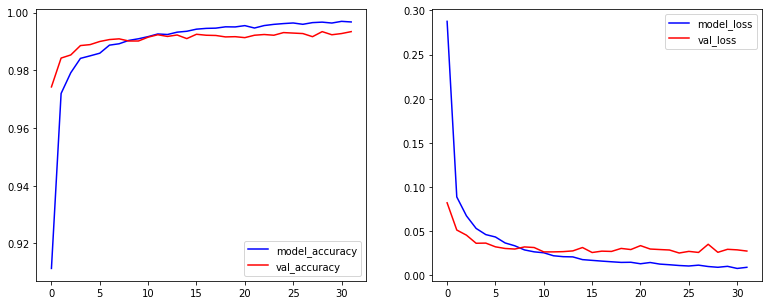

'loss': 0.009269346483051777 
'accuracy' : 0.9967708587646484 
'val_loss' : 0.027660006657242775 
'val_accuracy' : 0.9934166669845581


In [485]:
ig, ax = plt.subplots(1, 2,figsize=(13,5))
ax[0].plot(np.arange(32),convhist.history.get('accuracy'),color='blue',label='model_accuracy')
ax[0].plot(np.arange(32),convhist.history.get('val_accuracy'), color='red',label='val_accuracy')
ax[1].plot(np.arange(32),convhist.history.get('loss'), color='blue' ,label='model_loss')
ax[1].plot(np.arange(32),convhist.history.get('val_loss'), color='red',label='val_loss')
ax[0].legend()
ax[1].legend()
plt.show()
print("'loss':" ,convhist.history.get('loss')[-1], '\n' "'accuracy' :", convhist.history.get('accuracy')[-1],  '\n' "'val_loss' :", convhist.history.get('val_loss')[-1], '\n' "'val_accuracy' :" ,convhist.history.get('val_accuracy')[-1])

In [51]:
Xt = image_test/255                    
Xt = tf.cast(Xt, dtype=tf.float32)
Yt = label_test
Yt = tf.one_hot(Yt,10)

In [487]:
netconv.evaluate(Xt,Yt)

313/313 [==============================] - 1s 4ms/step - loss: 0.0251 - accuracy: 0.9937


[0.025101374834775925, 0.9937000274658203]

So we get 99.3% accuracy!!

# 1x1 Convolutions to reduce Layers

We can use a 1x1 conv layer to lower the enumber of parameters

In [519]:
inputs = keras.Input(shape = (28,28,1))
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
convbloc1 = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(1,1), activation='relu')(convbloc1)
x = layers.Conv2D(16, kernel_size=(1,1), activation='relu')(x)
convbloc2 = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(convbloc2)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
netconv = keras.Model(inputs, outputs, name="conv")
netconv.summary()

Model: "conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_73 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 5, 5, 32)          2080   

In [520]:
netconv.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
            loss = losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

In [5]:
X = image/255                    
X = tf.cast(X, dtype=tf.float32)
Y = label
Y = tf.one_hot(Y,10) 

In [521]:
convhist = netconv.fit(X,Y, epochs =10 ,batch_size=128, verbose=0, validation_split=0.2, shuffle=True)

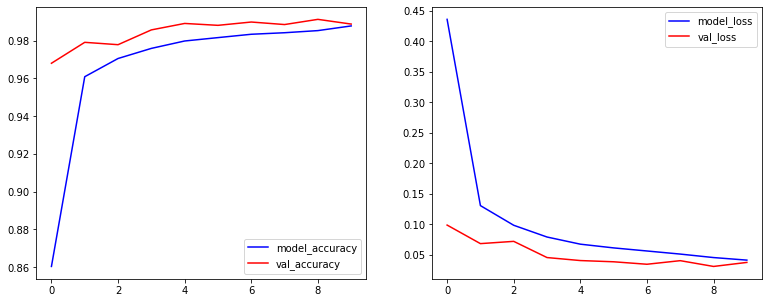

'loss': 0.04159068688750267 
'accuracy' : 0.9877708554267883 
'val_loss' : 0.03783249482512474 
'val_accuracy' : 0.9887499809265137


In [522]:
ig, ax = plt.subplots(1, 2,figsize=(13,5))
ax[0].plot(np.arange(10),convhist.history.get('accuracy'),color='blue',label='model_accuracy')
ax[0].plot(np.arange(10),convhist.history.get('val_accuracy'), color='red',label='val_accuracy')
ax[1].plot(np.arange(10),convhist.history.get('loss'), color='blue' ,label='model_loss')
ax[1].plot(np.arange(10),convhist.history.get('val_loss'), color='red',label='val_loss')
ax[0].legend()
ax[1].legend()
plt.show()
print("'loss':" ,convhist.history.get('loss')[-1], '\n' "'accuracy' :", convhist.history.get('accuracy')[-1],  '\n' "'val_loss' :", convhist.history.get('val_loss')[-1], '\n' "'val_accuracy' :" ,convhist.history.get('val_accuracy')[-1])

In [523]:
netconv.evaluate(Xt,Yt)

313/313 [==============================] - 1s 4ms/step - loss: 0.0314 - accuracy: 0.9907


[0.03141070529818535, 0.9907000064849854]

# Residual Nets & Batch Normalization

Resnets are a all of making it easier for your model to approximate the identity, i.e erasing some useless layers.

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_269 (Conv2D)            (None, 26, 26, 32)   320         ['img[0][0]']                    
                                                                                                  
 conv2d_270 (Conv2D)            (None, 24, 24, 64)   18496       ['conv2d_269[0][0]']             
                                                                                                  
 batch_normalization_33 (BatchN  (None, 24, 24, 64)  256         ['conv2d_270[0][0]']             
 ormalization)                                                                           

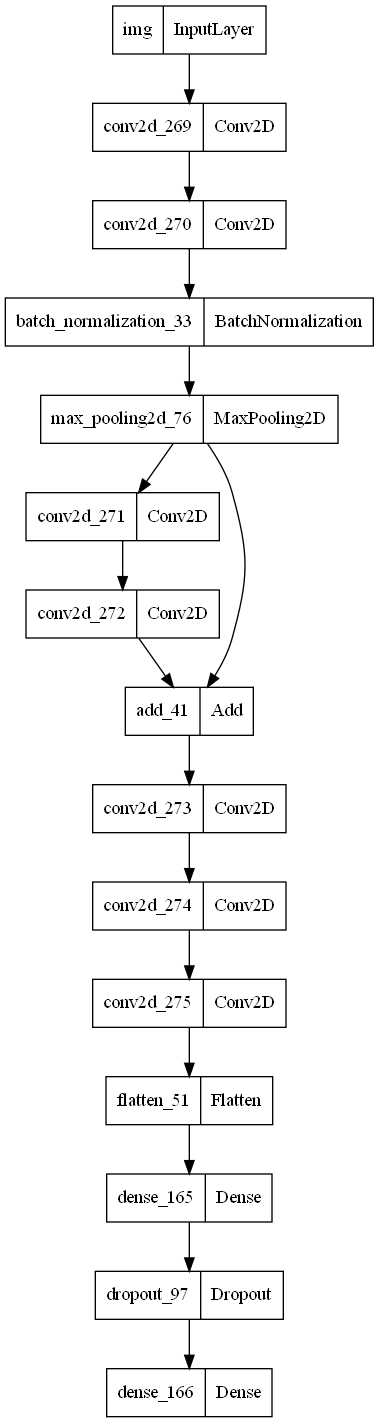

In [565]:
inputs = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu",)(block_2_output)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.Conv2D(32, 1, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

netconv = keras.Model(inputs, outputs, name="toy_resnet")
netconv.summary()
keras.utils.plot_model(netconv)

In [566]:
netconv.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
            loss = losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

In [567]:
convhist = netconv.fit(X,Y, epochs = 10 ,batch_size=128, validation_split=0.2, shuffle=True)

Epoch 1/10
375/375 [==============================] - 77s 204ms/step - loss: 0.2293 - accuracy: 0.9287 - val_loss: 0.2448 - val_accuracy: 0.9799
Epoch 2/10
375/375 [==============================] - 80s 212ms/step - loss: 0.0666 - accuracy: 0.9810 - val_loss: 0.0423 - val_accuracy: 0.9867
Epoch 3/10
375/375 [==============================] - 75s 200ms/step - loss: 0.0483 - accuracy: 0.9867 - val_loss: 0.0326 - val_accuracy: 0.9905
Epoch 4/10
375/375 [==============================] - 74s 199ms/step - loss: 0.0372 - accuracy: 0.9895 - val_loss: 0.0373 - val_accuracy: 0.9880
Epoch 5/10
375/375 [==============================] - 78s 209ms/step - loss: 0.0322 - accuracy: 0.9907 - val_loss: 0.0366 - val_accuracy: 0.9899
Epoch 6/10
375/375 [==============================] - 79s 210ms/step - loss: 0.0275 - accuracy: 0.9921 - val_loss: 0.0367 - val_accuracy: 0.9899
Epoch 7/10
375/375 [==============================] - 78s 208ms/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0315 - val_ac

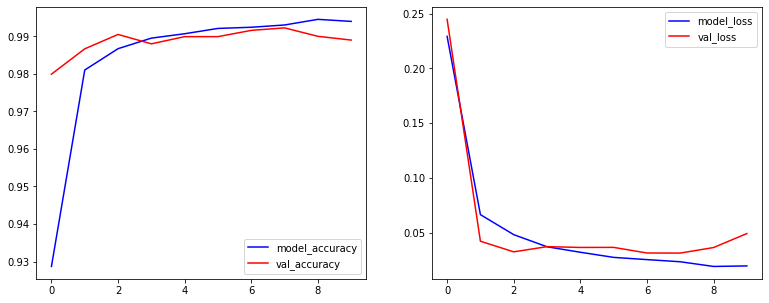

'loss': 0.019733335822820663 
'accuracy' : 0.9939791560173035 
'val_loss' : 0.049275707453489304 
'val_accuracy' : 0.9890000224113464


In [569]:
ig, ax = plt.subplots(1, 2,figsize=(13,5))
ax[0].plot(np.arange(10),convhist.history.get('accuracy'),color='blue',label='model_accuracy')
ax[0].plot(np.arange(10),convhist.history.get('val_accuracy'), color='red',label='val_accuracy')
ax[1].plot(np.arange(10),convhist.history.get('loss'), color='blue' ,label='model_loss')
ax[1].plot(np.arange(10),convhist.history.get('val_loss'), color='red',label='val_loss')
ax[0].legend()
ax[1].legend()
plt.show()
print("'loss':" ,convhist.history.get('loss')[-1], '\n' "'accuracy' :", convhist.history.get('accuracy')[-1],  '\n' "'val_loss' :", convhist.history.get('val_loss')[-1], '\n' "'val_accuracy' :" ,convhist.history.get('val_accuracy')[-1])

In [568]:
netconv.evaluate(Xt,Yt)

313/313 [==============================] - 3s 11ms/step - loss: 0.0430 - accuracy: 0.9905


[0.04296165332198143, 0.9904999732971191]

# A glimpse of Autoencoders

We can easily create a Toy Autoencoder (replicate our input)

In [6]:
test = ds.get('test')
for i in tqdm.tqdm(test.shuffle(test.cardinality()).batch(test.cardinality())):                     
    image_test, label_test = i['image'], i['label']
    
train = ds.get('train') 

for i in tqdm.tqdm(train.shuffle(train.cardinality()).batch(train.cardinality())):                     
    image, label = i['image'], i['label']

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


In [7]:
X = image/255                    
X = tf.cast(X, dtype=tf.float32)
Y = label
Y = tf.one_hot(Y,10) 
Xt = image_test/255
Xt = tf.cast(Xt, dtype=tf.float32)
Yt = label_test
Yt = tf.one_hot(Yt,10)

In [145]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = keras.Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_transpose_42 (Conv2D  (None, 14, 14, 32)       924

In [146]:
autoencoder.fit(X, X, batch_size=128, epochs=10, shuffle=1, validation_data=(Xt, Xt))

Epoch 1/10
469/469 [==============================] - 9s 17ms/step - loss: 0.1318 - val_loss: 0.0729
Epoch 2/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0712 - val_loss: 0.0691
Epoch 3/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0688 - val_loss: 0.0676
Epoch 4/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0677 - val_loss: 0.0667
Epoch 5/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0669 - val_loss: 0.0662
Epoch 6/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0663 - val_loss: 0.0657
Epoch 7/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0659 - val_loss: 0.0653
Epoch 8/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0656 - val_loss: 0.0650
Epoch 9/10
469/469 [==============================] - 9s 18ms/step - loss: 0.0653 - val_loss: 0.0648
Epoch 10/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0651 - val_lo

1/1 [==============================] - 0s 28ms/step


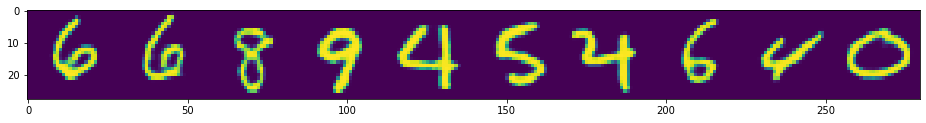

In [162]:
plt.figure(figsize=(16,16))

plt.imshow(np.concatenate(autoencoder.predict(np.array([random.choice(Xt) for i in range(10)])), axis=1))

The autoencoder is essencially an approximation of the identity...
<br> the cool part is that because of it's bottle neck (end of encoder) <br>
we obtain a form of compactification of the input.

In [152]:
import PIL

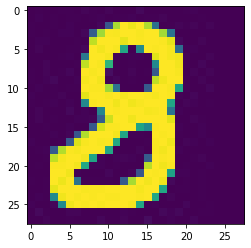

In [158]:
img = PIL.Image.open('8.jpg')               #digit 8 that I draw on Paint
img = np.array(img)
img = img/255
img = tf.constant(img)
img = tf.image.rgb_to_grayscale(img)
img = 1- img                                       #convert to negative
plt.imshow(img)  

Even thou the network was designed to replicate numbers... <br>
We can actually see that it actually learned how to replicate "shapes" in general

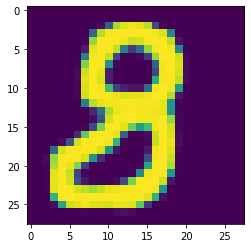

In [159]:
img = autoencoder(tf.expand_dims(img,0))
img = tf.squeeze(img,axis=0)
plt.imshow(img)

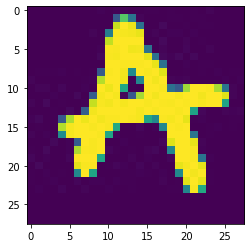

In [160]:
img = PIL.Image.open('A.jpg')
img = np.array(img)
img = img/255
img = tf.constant(img)
img = tf.image.rgb_to_grayscale(img)
img = 1- img
plt.imshow(img)                    

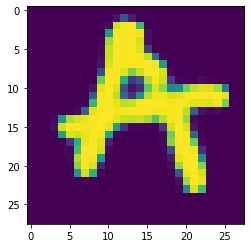

In [161]:
A = autoencoder(tf.expand_dims(img,0))
A = tf.squeeze(A,axis=0)
plt.imshow(A)

# Latent Space Distribution

Let's first separate our autoencoder into 2 different models i.e 
the encoder and the decoder <br>
We will also add a final denser layer on our encoder representing a 1D (a vector but with 2 parameters) latent space..


In [5]:
# Encoder

encoder_input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), padding="same")(encoder_input)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x =  layers.Conv2D(16, (3, 3), padding="same")(x)
x = layers.ReLU()(x)
x = x = layers.Conv2D(8, (3, 3), padding="same")(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dense(64, activation = 'relu')(x)
encoder_output = layers.Dense(2, activation = 'relu')(x)
encoder = keras.Model(encoder_input,encoder_output, name='encoder')
encoder.summary()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 re_lu_1 (ReLU)              (None, 14, 14, 32)        0         
                                                           

In [6]:
# Decoder
decoder_input = layers.Input(2)
x = layers.Dense(7*7*8, activation = 'relu')(decoder_input)
x = layers.Reshape((7,7,8))(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (2, 2), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (2, 2), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (2, 2), strides=1, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
decoder = keras.Model(decoder_input,decoder_output, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 392)               1176      
                                                                 
 reshape (Reshape)           (None, 7, 7, 8)           0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          2336      
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       16448     
 nspose)                                                         
                                                           

In [7]:
# Autoencoder
autoencoder_input = layers.Input((28,28,1))
x = encoder(autoencoder_input)
autoencoder_output = decoder(x)
autoencoderA = keras.Model(autoencoder_input, autoencoder_output, name="autoencoderA")
autoencoderA.summary()

Model: "autoencoderA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 132538    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         71929     
                                                                 
Total params: 204,467
Trainable params: 204,467
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoderA.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mse" )


In [11]:
autoencoderhist = autoencoderA.fit(X,X, epochs = 5 ,batch_size=128,  validation_data = (Xt,Xt))

Epoch 1/5
469/469 [==============================] - 18s 38ms/step - loss: 0.0378 - val_loss: 0.0378
Epoch 2/5
469/469 [==============================] - 18s 38ms/step - loss: 0.0374 - val_loss: 0.0371
Epoch 3/5
469/469 [==============================] - 18s 38ms/step - loss: 0.0371 - val_loss: 0.0382
Epoch 4/5
469/469 [==============================] - 18s 38ms/step - loss: 0.0370 - val_loss: 0.0366
Epoch 5/5
469/469 [==============================] - 18s 38ms/step - loss: 0.0366 - val_loss: 0.0371


1/1 [==============================] - 0s 22ms/step


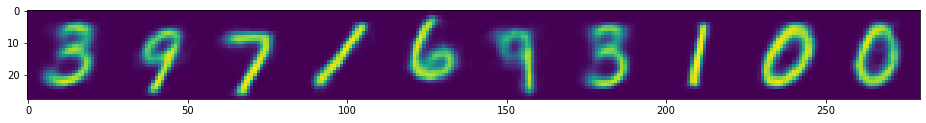

In [27]:
import random 

plt.figure(figsize=(16,16))

plt.imshow(np.concatenate(autoencoderA.predict(np.array([random.choice(Xt) for i in range(10)])), axis=1))

Notice that our encoder is worst than the last because we are <br>
compressing it to a 2 dim latent space, while before we were compressing to a
7x7x32 = 1568 latent space

1/1 [==============================] - 0s 17ms/step


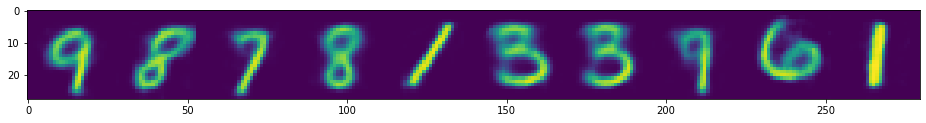

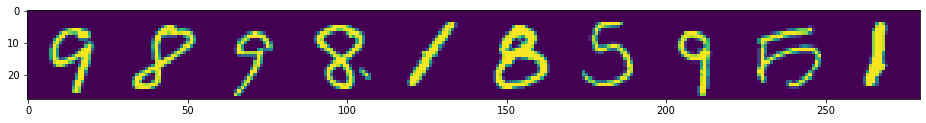

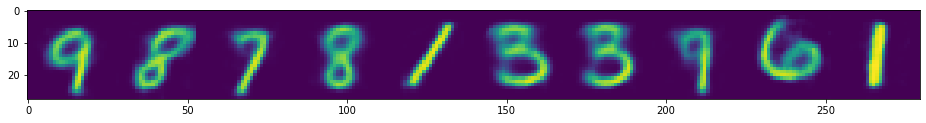

In [33]:
plt.figure(figsize=(16,16))
i,j = 50,60
plt.imshow(np.concatenate(autoencoderA.predict(X[i:j]),axis=1))
plt.figure(figsize=(16,16))
plt.imshow(np.concatenate(X[i:j],axis=1))
plt.figure(figsize=(16,16))
plt.imshow(np.concatenate(decoder.predict(encoder.predict(X[i:j])),axis=1))

Now we would like to plot the latent space distribution i.e
we would like to have a plot where each point is labeled with <br>
its value on the latent space and it's label...
That way we will be able to have an idea of where each number lives on the latent space. 
<br> For example :

In [ ]:
plt.imshow(X[12]) # This 6

In [55]:
# is mapped to this vector :
six_encoded = encoder(tf.expand_dims(X[12],axis=0))
six_encoded

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[7.9694986, 3.6468918]], dtype=float32)>

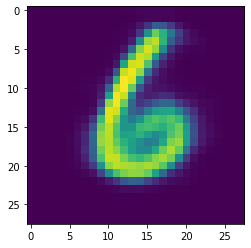

In [56]:
six = tf.squeeze(decoder(six_encoded), axis=0)
plt.imshow(six)

It's natural to expect that all 6's would lie close to this vector...<br>
so we should expect a cluster with 10 regions.. 

1/1 [==============================] - 0s 25ms/step


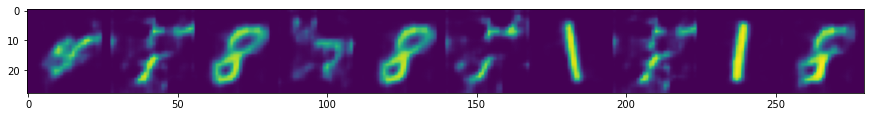

In [57]:
#Let's see what happens if we that an random sample of 10 vectors in the latent space
fig = plt.figure(figsize=(15, 15))
plt.imshow(np.concatenate(decoder.predict(np.random.normal(size=(10,2))),axis=1))


If we take a random sample we see that we cannot generate any reasonable number... <br>
but lets see what happens if we take a sample close to the vector 6     

1/1 [==============================] - 0s 16ms/step


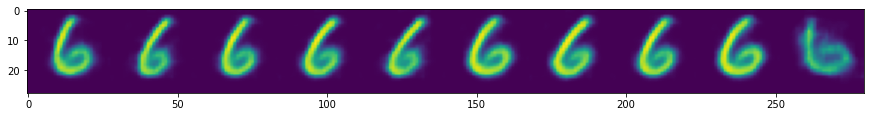

In [59]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(np.concatenate(decoder.predict(np.random.normal(loc = six_encoded, size=(10,2))),axis=1))

In fact thats what happens..

If we plt the distribution of the number on the latent space we get :

In [ ]:
pred = encoder.predict(Xt)
x = np.zeros(shape=10000)
y = np.zeros(shape=10000)
for i in range(10000):
    x[i],y[i] = pred[i]

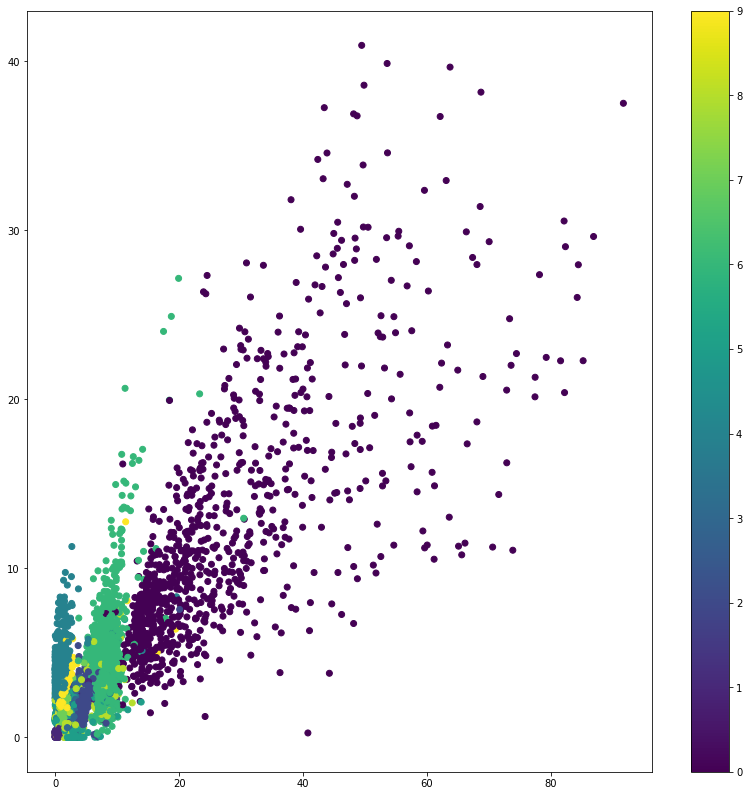

In [61]:
plt.figure(figsize=(14, 14))
plt.scatter(x,y,c=label_test)
plt.colorbar()

So we see that we in fact we obtain some cluster with 10 regions...<br>
some of this regions are really close because of our toy model..<br>
more distinct characters like 0 lie far away (all other characters have non-zero values at the center)

To make a good generative model we would like to make this distribution with less variance...<br>
so that any random sample would generate a reasonable output.<br>
This can be done with Variational Autoencoder.. that we will not dicuss for now.

# Call Backs & Save Your Model 

Now that we have a more or less working model we would like to save it... <br>
Another important thing we would like to do is save steps of it... this can be important to <br>
do earlystops or to help you better understand your model. 

In [26]:
#We define some callbacks: 

callback_list = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3), #stops model when it do not improve for 3 epochs
    tf.keras.callbacks.ModelCheckpoint(filepath='testcheck/model.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_accuracy', verbose = 1, save_best_only = True, mode = 'max'),   #save only val_acc when it improves(max)
    tf.keras.callbacks.CSVLogger('logs.csv')
    ]

In [27]:
#Let's rerun our best model 
#Model :
inputs = keras.Input(shape = (28,28,1))
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
netconv = keras.Model(inputs, outputs, name="MNIST_Conv")
netconv.summary()


Model: "MNIST_Conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0

In [28]:
#Compile
netconv.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
            loss = losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

In [29]:
hist = netconv.fit(X,Y, epochs = 32 ,batch_size=128,  validation_split = 0.2, callbacks=callback_list )

Epoch 1/32
371/375 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.9058
Epoch 1: val_accuracy improved from -inf to 0.97825, saving model to testcheck\model.01-0.07.hdf5
375/375 [==============================] - 3s 8ms/step - loss: 0.3007 - accuracy: 0.9064 - val_loss: 0.0722 - val_accuracy: 0.9783
Epoch 2/32
373/375 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9716
Epoch 2: val_accuracy improved from 0.97825 to 0.98317, saving model to testcheck\model.02-0.06.hdf5
375/375 [==============================] - 3s 8ms/step - loss: 0.0905 - accuracy: 0.9717 - val_loss: 0.0562 - val_accuracy: 0.9832
Epoch 3/32
372/375 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9787
Epoch 3: val_accuracy improved from 0.98317 to 0.98600, saving model to testcheck\model.03-0.04.hdf5
375/375 [==============================] - 3s 8ms/step - loss: 0.0682 - accuracy: 0.9787 - val_loss: 0.0438 - val_accuracy: 0.9860
Epoch 4/32
372/375 

In [30]:
netconv.evaluate(Xt,Yt)

313/313 [==============================] - 1s 2ms/step - loss: 0.0213 - accuracy: 0.9935


[0.021328218281269073, 0.9934999942779541]

So we see that we had a early stop at epoch 17

In [32]:
netconv.save('modelsavetest') #saving model

INFO:tensorflow:Assets written to: modelsavetest\assets


INFO:tensorflow:Assets written to: modelsavetest\assets


In [34]:
a = tf.keras.models.load_model('modelsavetest') #loading model

In [35]:
a.summary()

Model: "MNIST_Conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0

In [36]:
a.evaluate(Xt,Yt)

313/313 [==============================] - 1s 3ms/step - loss: 0.0213 - accuracy: 0.9935


[0.021328218281269073, 0.9934999942779541]

# Inside The Net (First Layers)

We can check what is happening on the convolutional layers...

In [223]:
activation1 = netconv.layers[1](X[:32]) #first conv layers
activation2 = netconv.layers[3](netconv.layers[2](netconv.layers[1](X[:32]))) #second conv layer


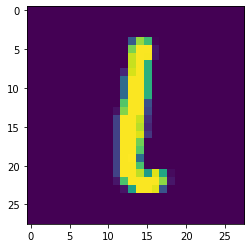

In [172]:
plt.imshow(X[1])

In [131]:
tf.shape(activation[0])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([26, 26, 32])>

100%|██████████| 30/30 [00:00<00:00, 90.73it/s]


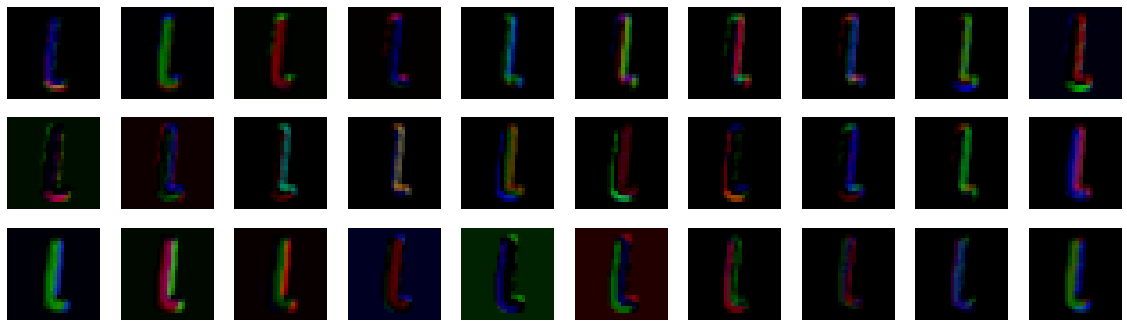

In [226]:
fig = plt.figure(figsize=(20, 20)) 
for i in tqdm.tqdm(range(30)):                   #all channels 
    fig.add_subplot(10,10, i+1)
    plt.imshow(activation1[1][:,:,i:i+3])
    plt.axis('off')


100%|██████████| 30/30 [00:00<00:00, 89.67it/s]


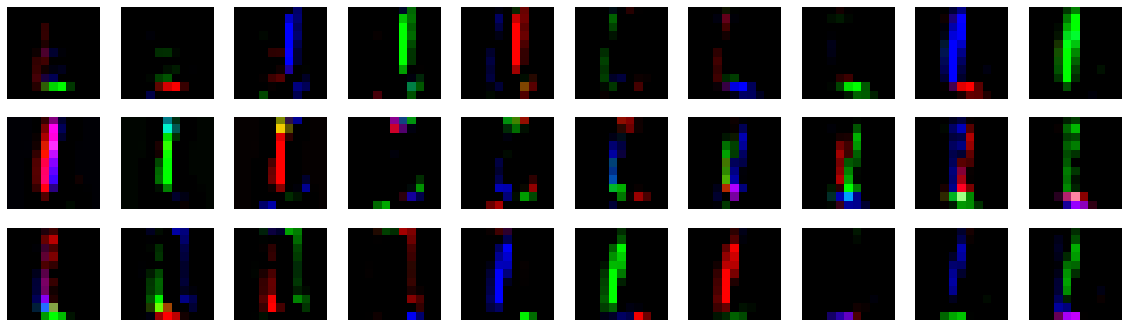

In [222]:
fig = plt.figure(figsize=(20, 20))
for i in tqdm.tqdm(range(30)):                    #all channels 
    fig.add_subplot(10,10, i+1)
    img = np.array(activation2[1][:,:,i:i+3])
    img = np.clip(img,0,1)
    plt.imshow(img)
    plt.axis('off')

# Toy Data Augmentation 

One of the most powerfull ways of making your model generalize better, beside changing the topology, <br>
is by Data Augmentation... in our case of images this would involve transformations to our image...<br>
like fliping it, shearing, rotating etc... Now we will see if for our case this simple transformations will improve<br>
our classification model.

Just as an example we will apply the following Augmentation, where for each image we <br>
remove 5% of it's pixels randomly.

In [103]:
#Let's define a function
def Erasor(inputs):
    erasor = np.random.choice([0,1], size= (28,28), p=[0.05,0.95])
    inputs = tf.squeeze(inputs,axis=-1)
    return tf.expand_dims(erasor*inputs,axis=-1)

In [104]:
layerErasor = layers.Lambda(Erasor,output_shape=[None,28,28,1])

In [105]:
#Input
inputs = keras.Input(shape = (28,28,1))

#Data_Augmentation
x = layers.RandomZoom(0.2)(inputs)
x = layerErasor(x)
#Model
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
netconv = keras.Model(inputs, outputs, name="MNIST_Conv")
netconv.summary()


Model: "MNIST_Conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 random_zoom_12 (RandomZoom)  (None, 28, 28, 1)        0         
                                                                 
 lambda_7 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_39 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 11, 11, 64)        18496     
                                                        

In [106]:
#Compile
netconv.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
            loss = losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

In [107]:
hist = netconv.fit(X,Y, epochs = 10 ,batch_size=128,  validation_split = 0.2)

Epoch 1/10
375/375 [==============================] - 4s 8ms/step - loss: 0.3390 - accuracy: 0.8965 - val_loss: 0.0823 - val_accuracy: 0.9739
Epoch 2/10
375/375 [==============================] - 3s 8ms/step - loss: 0.1092 - accuracy: 0.9654 - val_loss: 0.0563 - val_accuracy: 0.9833
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0812 - accuracy: 0.9741 - val_loss: 0.0448 - val_accuracy: 0.9864
Epoch 4/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0654 - accuracy: 0.9789 - val_loss: 0.0395 - val_accuracy: 0.9882
Epoch 5/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0606 - accuracy: 0.9807 - val_loss: 0.0348 - val_accuracy: 0.9892
Epoch 6/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0507 - accuracy: 0.9841 - val_loss: 0.0333 - val_accuracy: 0.9902
Epoch 7/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0485 - accuracy: 0.9848 - val_loss: 0.0317 - val_accuracy: 0.9907
Epoch 

In [108]:
netconv.evaluate(Xt,Yt)

313/313 [==============================] - 1s 3ms/step - loss: 0.0219 - accuracy: 0.9929


[0.021949660032987595, 0.992900013923645]